# Diabetes daignostic data evaluation and application
## Aaron Simpkiss C964 Capstone project

This notebook walks through the process of creating a data based diabetes diagnosis tool from raw data to beta version of an innteractive application that can make a rapid diabetes diagnosis.

### The first step is to import the necessary libraries.

In [1]:
import piplite
await piplite.install('seaborn')
import seaborn as sns
await piplite.install('ipywidgets')
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, Dropdown, Label, BoundedFloatText, BoundedIntText, Output
import math
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn import linear_model, metrics, model_selection, tree
from matplotlib import pyplot as plt

### Next, we create a function to parse and clean the dataframe. 

Defining a function to do this instead of just using the .replace() command on the dataframe allows us to call the same function again when entering patient information into the application.

We also import the data from the CVS file and run the dataframe through the clean() function, saving it as df.

In [2]:
# Function that cleans input data and turns it all into numeric values
def clean(data):
    inputs = ['Female','female','F','f','Male','male','M','m','Other','other','O','o','No Info','no info','N/A','n/a','Never','never','Ever','ever','Former','former','Not Current','not current','Current','current','Yes','yes','Y','y','No','no','N','n']
    outputs = [0,0,0,0,1,1,1,1,2,2,2,2,0,0,0,0,0,0,1,1,2,2,3,3,4,4,1,1,1,1,0,0,0,0]
    cleaned_data = data.replace(inputs, value=outputs)
    return cleaned_data

# Imported and cleaned dataframe
df = clean(pd.read_csv("diabetes_prediction_dataset.csv"))

### Now we want to examine the data
We will take a preliminary look at the data to see if we can identify any variables that are strongly correlated with the diabetes value.

We will be looking for higher values along the bottom row of this heat map to identify stronger correlations.

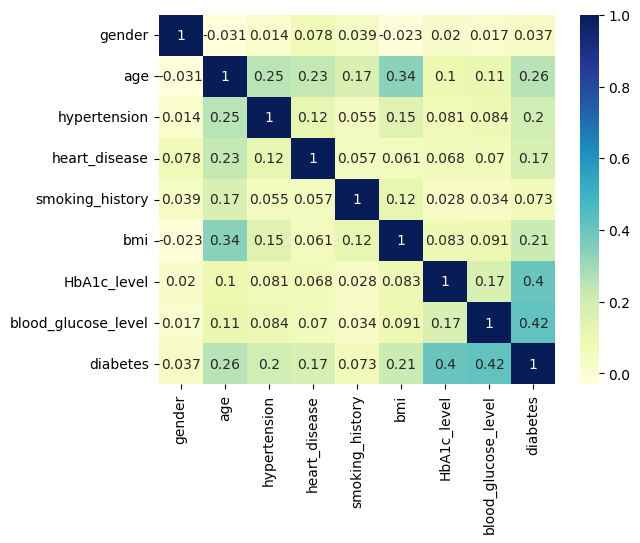

In [92]:
heatmap = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show(heatmap)

### There is some correlation
From the correlation heatmap we can see that blood glucose level, HbAic level, and age are the 3 variables most correlated with diabetes in this dataset.

In order to see if there are any clearly recognizable deliniations based on these variables, we will generate a 3 dimensional scatter plot so we can visualize the data. We are only visualizing a small random sample of the data though, because plotting all 100,000 data points would make the plot hard to read.

The data points will be deliniated by color, with red being a diabetic and blue a non-diabetic.

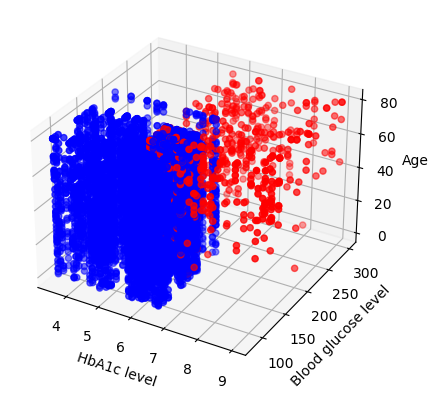

In [17]:
df1 = df.sample(frac = 0.075, random_state = 200)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = df1['HbA1c_level']
ys = df1['blood_glucose_level']
zs = df1['age']
ax.scatter(xs, ys, zs, c=df1['diabetes'],cmap='bwr')

ax.set_xlabel('HbA1c level')
ax.set_ylabel('Blood glucose level')
ax.set_zlabel('Age')

plt.show()

### The scatterplot gives us some insight
We can see that there actually are well deliniated HbA1c and blood glucose ranges that define both diabetics and non-diabetics. These ranges are likely what physicians currently use to decide to pursue formal testing of a patient. Unfortunately, there is a lot of overlap right in the middle of the ranges that is not deliniated in any recognizable way. This zone of overlap is likely where many currently undiagnosed diabetics are. 


# Introducing machine learning
We are going to use machine learning to hopefully disambiguate that area of overlap. We start by splitting the dataset into training and testing portions.

In [5]:
y = df.values[:,8]
X = df.values[:,0:8]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.3)

### Machine learning model selection
We will select two different predictive models to be compared in terms of accuracy. 

The first is logistic regression because our research has indicated it is well suited to this type of application.

The second is a decision tree classifier because it is fast and handles outliers well.

### The two models are declared, trained, tested, and evaluated against each other

In [93]:
# Declare the models
log = linear_model.LogisticRegression(max_iter=50000)
dtc = tree.DecisionTreeClassifier()

# Train the models
trained_log = log.fit(X_train,y_train)
trained_dtc = dtc.fit(X_train, y_train)

# Test the trained models
y_pred_log = trained_log.predict(X_test)
y_pred_dtc = trained_dtc.predict(X_test)

# Print accuracy scores of both models
print('Logistic regression overall accuracy = {}%'.format(metrics.accuracy_score(y_test, y_pred_log)*100))
print('Decision tree overall accuracy = {}%'.format(metrics.accuracy_score(y_test, y_pred_dtc)*100))

Logistic regression overall accuracy = 96.06666666666666%
Decision tree overall accuracy = 95.33%


### The two models seem very similar
Because the two models perform so similarly, we will have to perform a deeper analysis of the accuracy data.

We will begin this process by calculating the confidence rating of all predictions made by the logistic regression model.

In [7]:
# List of P-values for the logistic regression predictions
y_prob_log = log.predict_proba(X_test)

# Function that modifies P-value into a confidence percentage
def calc_confidence(prob):
    if prob < 0.5:
        prob = 1 - prob
    confidence = (prob-0.5)*200
    return round(confidence,4)

# Create confidence list from the P-values
confidence=[]
for x in y_prob_log[:,1]:
    confidence.append(calc_confidence(x))

### Now we affiliate the confidence ratings with any mistakes
We create lists of the incorrect predictions made by both models. This is accomplished by adding the list of actual diabetes values to each of the lists of diabetes predictions, then changing any value of 2 in the resulting list to 0. This works because the diabetes data and predictions are binary values, and the lists are still in their original orders. So the results of the list addition will be 0 if both lists say no diabetes and 2 if both lists say yes diabetes, but will only result in a value of 1 if the diabetes prediction does not match the diabetes actual.

We create arrays by attaching the confidence ratings list to both lists of mistaken diagnoses.

In [20]:
# Creates arrays of mistakes made by each model at given confidence ratings
log_mistakes = y_test + y_pred_log
log_mistakes[log_mistakes == 2.0] = 0.0

dtc_mistakes = y_test + y_pred_dtc
dtc_mistakes[dtc_mistakes == 2.0] = 0.0

# Creates arrays by attaching confidence list to mistake lists
log_mistakes_array = np.column_stack([confidence, log_mistakes])
dtc_mistakes_array = np.column_stack([confidence, dtc_mistakes])

### We want to see the data though
So we are then going to create a couple more datasets to evaluate the accuracy data in a couple different ways.

First we create a dataset for a comparative histplot. Then we create a dataset of model accuracy across an axis of confidence rating. 

In [94]:
# Create one array of both log and dtc for a histplot comparison, log = 1, Tree = 2
double_conf = np.append(confidence, confidence)
shifted_dtc = dtc_mistakes * 2
both_mistakes = np.append(log_mistakes,shifted_dtc)

# Remove correct values
both_mistakes_array = np.column_stack([double_conf, both_mistakes])
cleaned_both = np.delete(both_mistakes_array, np.where(
    (both_mistakes_array[:,1] == 0)), axis=0)

# Creates a data frame of the percentage of incorrect diagnoses the two models made at a given confidence% with increment setting the range
binned_log_accuracy = []
log_mistake_count = []
binned_dtc_accuracy = []
dtc_mistake_count = []
confidence_range = []

x = 0
i = 0
log_mis = 0
log_tot = 1
dtc_mis = 0
dtc_tot = 1
increment = 5
while x < 100:
    while i < len(log_mistakes_array):
        if log_mistakes_array[i,0] > x and log_mistakes_array[i,0] < x + increment:
            if log_mistakes_array[i,1] == 1.0:
                log_mis = log_mis + 1
            log_tot = log_tot + 1
        if dtc_mistakes_array[i,0] > x and dtc_mistakes_array[i,0] < x + increment:
            if dtc_mistakes_array[i,1] == 1.0:
                dtc_mis = dtc_mis + 1
            dtc_tot = dtc_tot + 1
        i = i + 1
    binned_log_accuracy.append(round(((log_tot-log_mis)/log_tot)*100,2))
    binned_dtc_accuracy.append(round(((dtc_tot-dtc_mis)/dtc_tot)*100,2))
    log_mistake_count.append(log_mis)
    dtc_mistake_count.append(dtc_mis)
    x = x + increment
    confidence_range.append(x)
    i = 0
    log_mis = 0
    log_tot = 1
    dtc_mis = 0
    dtc_tot = 1
    
mistake_percentages = []
mistake_percentages = np.column_stack([binned_log_accuracy, binned_dtc_accuracy])
mistake_df=pd.DataFrame(mistake_percentages, index=confidence_range, columns = ['Logistic regression','Decision tree'])

### Now the data can be visualized
We plot both datasets so we can compare the mistakes made and general accuracy of both models across the confidence rating of the logistic regression model

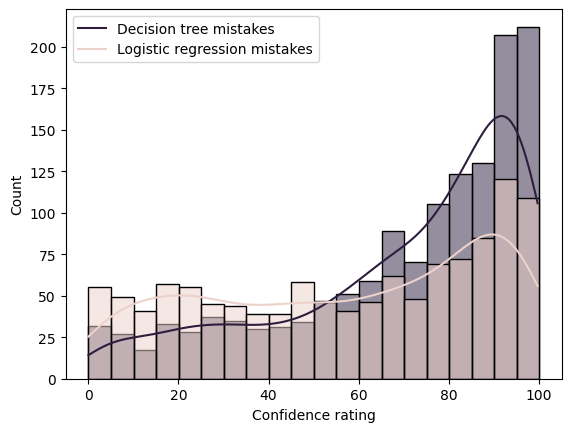

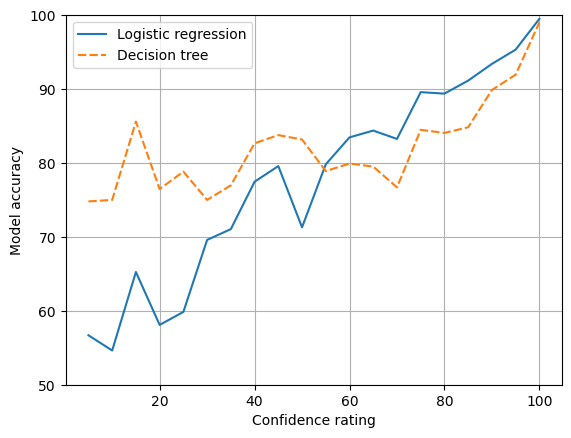

In [66]:
# Histplot of total mistakes made at a given confidence level for each model
vis1 = sns.histplot(data=cleaned_both, x=cleaned_both[:,0], hue = cleaned_both[:,1], multiple='layer',binwidth=5, kde=True)
plt.legend(labels=["Decision tree mistakes","Logistic regression mistakes"])
plt.xlabel('Confidence rating')
plt.show(vis1)

# Plot of accuracy at a given confidence level for each model
vis2 = sns.lineplot(data=mistake_df).set_ylim(50,100)
plt.grid()
plt.xlabel('Confidence rating')
plt.ylabel('Model accuracy')
plt.show(vis2)

### What can we see
Looking at the data this way shows us a few things. We can see is that at higher confidence levels, the logisic regression model makes fewer mistakes and has higher accuracy than the decision tree model, but that the decision tree model dramatically outperforms the logistic regression model in accuracy at lower confidence ratings. Also, we notice that both models make more mistakes at higher confidence levels, despite being more accurate, which seems counterintuitive. In order to help understand this, we will plot a histplot summing the predictions made across the confidence ratings.

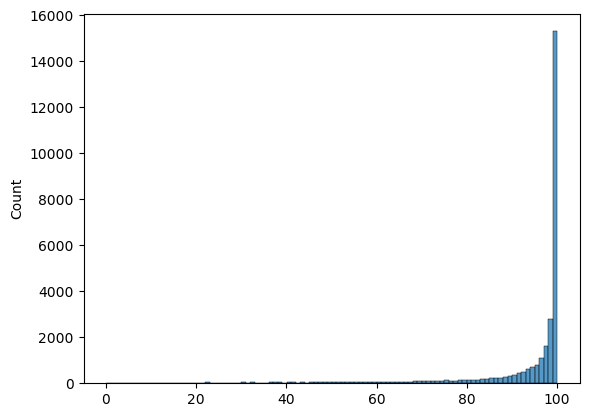

In [73]:
vis3 = sns.histplot(data=confidence, binwidth=1)
plt.show(vis3)

### It's very one-sided
This plot sheds some light on the previous plots that seemed to be at odds. The overwhelming majority of predictions were made with high confidence ratings, which is how both the accuracy of the models and the total mistakes they made were able to increase as the confidence of the model increased.

Looking at the relatively small number of predictions made at lower confidence levels, we can choose to go forward with the logistic regression model because even though the two are very comparable in terms of overall accuracy, it consistently outperforms the decision tree model when dealing with the largest share of the predictions.

To further justify the choice of predictive model for the application, this pie chart summarizes the accuracy and volume of the logistic regression models predictions.

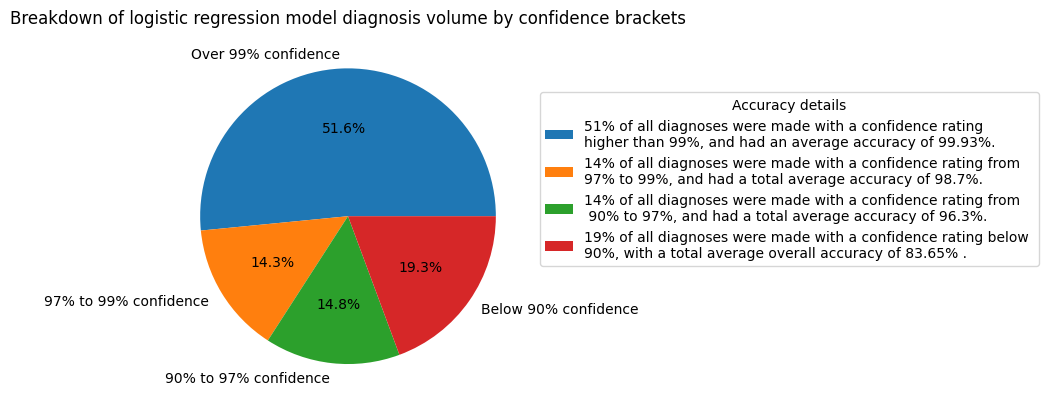

In [78]:
# Lists confidence ratings of every incorrect prediction the logistic regression maade, to be compared against all predictions made to calculate incremental accuracy 
log_mistakes_confidence = np.delete(log_mistakes_array, np.where(
    (log_mistakes_array[:,1] == 0)), axis=0)[:,0]

top = 99
high = 97
mid = 90
count = len(confidence)

top_count = sum(i > top for i in confidence)
high_count = sum(i > high for i in confidence) - top_count
mid_count = sum(i > mid for i in confidence) - (top_count + high_count)
low_count = count - (top_count + high_count + mid_count)

top_mistake_count = sum(i > top for i in log_mistakes_confidence)
high_mistake_count = sum(i > high for i in log_mistakes_confidence) - top_mistake_count
mid_mistake_count = sum(i > mid for i in log_mistakes_confidence) - (top_mistake_count + high_mistake_count)
low_mistake_count = len(log_mistakes_confidence) - (top_mistake_count + high_mistake_count + mid_mistake_count)

top_key = str(int((top_count/count)*100)) + '% of all diagnoses were made with a confidence rating \nhigher than ' + str(top) + '%, and had an average accuracy of ' + str(round(((top_count-top_mistake_count)/top_count)*100,2)) +'%.'
high_key = str(int((high_count/count)*100)) + '% of all diagnoses were made with a confidence rating from \n' + str(high) + '% to ' + str(top) + '%, and had a total average accuracy of ' + str(round(((high_count-high_mistake_count)/high_count)*100,2)) + '%.'
mid_key = str(int((mid_count/count)*100)) + '% of all diagnoses were made with a confidence rating from \n ' + str(mid) + '% to ' + str(high) + '%, and had a total average accuracy of ' + str(round(((mid_count-mid_mistake_count)/mid_count)*100,2)) +'%.'
low_key = str(int((low_count/count)*100)) + '% of all diagnoses were made with a confidence rating below \n' + str(mid) + '%, with a total average overall accuracy of ' + str(round(((low_count-low_mistake_count)/low_count)*100,2)) +'% .'

top_label = 'Over ' + str(top) + '% confidence'
high_label = str(high) + '% to ' + str(top) + '% confidence'
mid_label = str(mid) + '% to ' + str(high) + '% confidence'
low_label = 'Below ' + str(mid) + '% confidence'

data = [top_count, high_count, mid_count, low_count]
keys = [top_key, high_key, mid_key, low_key]
labels = [top_label, high_label, mid_label, low_label]


fig, ax = plt.subplots()

wedges, texts,text = ax.pie(data, labels = labels, autopct='%1.1f%%')
ax.set(title="Breakdown of logistic regression model diagnosis volume by confidence brackets")
ax.legend(wedges, keys,
          title="Accuracy details",
          loc="center left",
          bbox_to_anchor=(1, 0.1, 0.5, 1))

plt.show()

### We are going with the logistic regression model
With the model chosen and the decision supported with data, we will now create a simple beta version of an application that utilizes this trained and measured model.

In [91]:
print('Diabetes daignostic tool v0.2')
form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between'
)
gender = Dropdown(options=['Female', 'Male', 'Other'])
age = BoundedFloatText(value=18, min=1, max=100, step=1)
hypertension = Dropdown(options=['No', 'Yes'])
heart_disease = Dropdown(options=['No', 'Yes'])
smoking_history = Dropdown(options=['No Info', 'Never', 'Ever', 'Former', 'Not Current', 'Current'])
bmi = BoundedFloatText(value=20.0, min=10.0, max=100.0, step=0.1)
HbA1c_level = BoundedFloatText(value=4.0, min=3.5, max=9, step=0.1)
blood_glucose = BoundedIntText(value=100, min=80, max=300, step=1)

form_items = [
    Box([Label(value='Gender'), gender], layout=form_item_layout),
    Box([Label(value='Age'), age], layout=form_item_layout),
    Box([Label(value='Hypertension'), hypertension], layout=form_item_layout),
    Box([Label(value='Heart disease'), heart_disease], layout=form_item_layout),
    Box([Label(value='Smoking history'), smoking_history], layout=form_item_layout),
    Box([Label(value='BMI'), bmi], layout=form_item_layout),
    Box([Label(value='HbA1c level'), HbA1c_level], layout=form_item_layout),
    Box([Label(value='Blood glucose'), blood_glucose], layout=form_item_layout)
]

form = Box(form_items, layout=Layout(
    display = 'flex',
    flex_flow = 'column',
    border = 'solid 2px',
    align_items = 'stretch',
    width = '40%'
))

diagnosis_button = widgets.Button(description="Make Diagnosis")
clear_button = widgets.Button(description="Clear")
output = widgets.Output()

display(form, diagnosis_button, clear_button, output)

def diagnose(b):
    with output:
        patientdict = {'Patient':[gender.value, age.value, hypertension.value, heart_disease.value, smoking_history.value, bmi.value, HbA1c_level.value, blood_glucose.value]}
        patient = clean(pd.DataFrame.from_dict(data=patientdict, orient='index'))
        
        diagnosis = int(log.predict(patient))
        if diagnosis == 0:
            diabetes = 'Non-diabetic'
        else:
            diabetes = 'Diabetic'
            
            
        certainty = calc_confidence(float(log.predict_proba(patient)[:,0]))
        up = (math.ceil(certainty*1)/1)
        down = (math.floor(certainty*1)/1)
        fig_count = sum(i > down and i < up for i in confidence)
        fig_mistake_count = sum(i > down and i < up for i in log_mistakes_confidence)        
        accuracy = round(((fig_count-fig_mistake_count)/fig_count)*100,4)
        
        print('The diagnosis of this patient based on the entered health metrics is: {}.'.format(diabetes))
        print('The application is {}% confident in this diagnosis and has historically demonstrated'.format(certainty))
        print('to be {}% accurate when making diagnoses with confidence levels between {}% and {}%.'.format(accuracy, down, up))
        print('If the confidence in this diagnosis is low, you should pursue traditional testing and diagnosis')
def clear(b):
    with output:
        output.clear_output()

diagnosis_button.on_click(diagnose)
clear_button.on_click(clear)

Diabetes daignostic tool v0.2


Box(children=(Box(children=(Label(value='Gender'), Dropdown(options=('Female', 'Male', 'Other'), value='Female…

Button(description='Make Diagnosis', style=ButtonStyle())

Button(description='Clear', style=ButtonStyle())

Output()

### It is simple and efficient
The application meets the W.A.H.P. medical groups need for a fast and accurate tool for diagnosing diabetes in its patients. Diagnoses made with high levels of confidence can essentially be taken at face value because the model is very accurate at very high confidence levels. A diagnosis made with a lower confidence rating should be second checked by a physician with traditional testing.